This notebook is intetended to analyze the individual year seasonal cycles using the ARMOR3D dataset.

In [1]:
#!/bin/python3

#########################
######### ROUTINE TO PLOT THE SEASONAL MEAN OF ANY VARIABLE OVER AN ALREADY 
######### SELECTED REGION.
#########################


import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

import datetime
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
regions = {
    'lab': {
        'lon' : (-55, -51),
        'lat' : (56, 59),
        'name' : 'Labrador Sea'
    },
    'irm': {
        'lon' : (-39, -35),
        'lat' : (58, 61),
        'name' : 'Irminger Sea'
    },
    'gul': {
        'lon' : (-57, -53),
        'lat' : (34, 38),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-20, -16),
        'lat' : (50, 53),
        'name' : 'North East Sea'
    }
}

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    }
}


In [3]:
## Function to crop the dataset
def Crops(coord, d_set):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    name_fig = reg_ext[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)


def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Map(ax, region, xtick, ytick):
    """
        Map is a function that helps to plot the map on a certain projection
        of a region. It always uses 50m definition of coastlines.

        Parameters:
        ------------
        ax : axes
            Current axes object in which is drawn the map.

        region : list
            Set of limit coordinates of the region to plot.
            It has the shape [lon1, lon2, lat1, lat2]

        xtick : np.array
            array containing the number and spacement of ticks 
            in x-axis.

        ytick : np.array
            Array containing the number and spacement of ticks 
            in y-axis.
    """
    ax.set_global()
    ax.coastlines('50m')
    ax.set_xticks(xtick, crs=ccrs.PlateCarree())
    ax.set_yticks(ytick, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')



## Need to make this a little bit more general, also in the extend. by now extends just to max
def Plot_2D(data_set, reg, *cm_levs, t=None, cmap=None, ext=None, cont_line=False, nlines=None):
    """
        Plot_2D is a function that plots a 2D variable using a
        colormap over a spatial region. It makes use of the external 
        functions 'Grid' and 'Map'. It also makes use of the dictionary 
        'reg_ext', to get the spatial delimitations. This works only
        for DataArray type and to plot MLD. The pre-defined cmap is 
        'magma_r'.
        
        Parameters:
        ------------
        data_set : DataArray
            Current axes object in which is drawn the map. It can
            be a complete DataArray, or just the values for one of
            the variables.
            
        reg : string
            Abreviation name that identifies the region in 
            which the plot is being done. It must be defined
            inside the dictionary 'reg_ext'.
            
        cm_levs : tuple, integers
            It contains the parameters for the color bar. The 
            order is: minimum, maximum, #of levels
        
        t : integer
            Timestep to plot.
        
        cmap : String
            Name of the color map to use. Default is 'magma_r'
        
        ext : string
            Extention of the color bar. Default is 'max'
            
        cont_line : Boolean
            If True we allow to plot a second contour plot of SSH. 
            On top of the MLD heat map.
            If False, this function plots a heat map of the variable 
            set by parameter 'data_set'.
            
        nlines : integers
            Is the number of lines to plot the contour plot. It is 
            optional, and is necessary when cont_line=True.
        
        Output:
        ------------
        ax : axes
    """
    
    # Shaping the plot
    x_n, y_n = Grid(data_set)
    projection = ccrs.PlateCarree(360)
    
    # Getting the delimitations and ticks
    lon1, lon2 = reg_ext[reg]['lon']
    lat1, lat2 = reg_ext[reg]['lat']
    xtick = np.linspace(lon1, lon2, num=9)
    ytick = np.linspace(lat1, lat2, num=4)
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat
    
    # If we want to plot MLD and SSH, or other thing, without SSH countours
    if cont_line:
        if not t:
            variable1 = data_set.mlotst
            variable2 = data_set.zo[0]
        else:
            variable1 = data_set.mlotst[t]
            variable2 = data_set.zo[t,0]
    else:
        if not t:
            variable1 = data_set
        else:
            variable1 = data_set[t]
        
    if not cmap:
        cmap = 'plasma_r'
        
    
    if ext:
        ext = ext
    else:
        ext = 'max'

    # Start of the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(10,5))    
    
    Map(ax, region, xtick, ytick)
    
    # Here plot the variable using a heat map, defining also color bar
    contr1 = ax.contourf(x_n, y_n, variable1, 
                         levels=np.linspace(cm_levs[0], cm_levs[1], cm_levs[2]),
                         cmap=cmap, extend=ext)
    cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                        label='MLD [m]', extend=ext)  
    # Here adding an extra layer of SSH at surface using countour lines
    if cont_line:
        contr2 = ax.contour(x_n, y_n, variable2, nlines, linewidths=0.5, colors='k')
    
    # Saving the figure
    ##if save:
    ##    fig.savefig(os.path.abspath(os.path.sep.join([".","dummy_images","Noe_%0.4d.png" % it])))

    return(ax)
    
    
def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)


def Limits(data_set):
    
    mn = data_set.min(skipna=True).values
    mx = data_set.max(skipna=True).values
    return(mn, mx)
    

In [4]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################

dir_1 = '../../../New_ARMOR/'
dir_15 = '/net/krypton/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'

dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'


fl_n1 = 'NARMOR_*.nc'
fl_n15 = 'ARMOR_*.nc'

c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')
c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)

/usr/local/lib/python3.5/dist-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/usr/local/lib/python3.5/dist-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)
/usr/local/lib/python3.5/dist-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/usr/local/lib/python3.5/dist-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason

In [22]:
d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

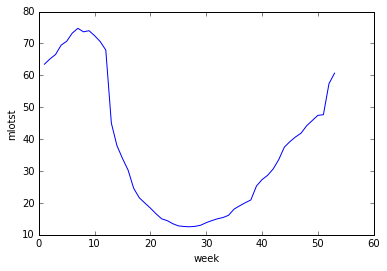

In [18]:
coord = 'gul'
lon1, lon2 = regions[coord]['lon']
lat1, lat2 = regions[coord]['lat']
name_fig = regions[coord]['name'] + '\n MLD Seasonal Cycle'

gulf = Crops(coord, c_armor1)

mean = gulf.groupby('time.week').mean(dim=('longitude', 'latitude', 'time'), skipna=True)
stdv = gulf.groupby('time.week').std(dim=('longitude', 'latitude', 'time'), skipna=True)


In [26]:
d1 = datetime.datetime(2000,1,1)
d2 = datetime.datetime(2000,12,31)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
mean.coords['time'] = (('time'), weeks)
stdv.coords['time'] = (('time'), weeks)

In [ ]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
           

In [ ]:
%matplotlib notebook

plt.close()
plt.errorbar(mean.time.values, mean.mlotst, stdv.mlotst, linestyle='-')

plt.fill_between(mean.time.values, mean.mlotst-stdv.mlotst,
                 mean.mlotst+stdv.mlotst, alpha=0.3)

plt.xticks(np.arange(mean.time.size, step=4.5), months, rotation=20)
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
#%matplotlib notebook

yrs = [i for i in range(2006,2006,1)]

datm_am.plot.line(label='ARMOR-3D monthly', marker='o')
datm_aw.plot.line(label='ARMOR-3D weekly', marker='^')
datm_i[:,0].plot.line(label='ISAS', marker='*')

plt.axvline(x='31-Mar-2012', color='k')
plt.axvline(x='30-Sep-2012', color='k')

plt.ylabel('Mixed Layer Depth')
plt.legend(loc='upper right')
plt.title(name_fig)
plt.grid()
plt.plot(figsize=(15, 7.5))
plt.show()
#plt.savefig(name_fig, bbox_inches='tight')

In [ ]:
g = datm_aw.time

a = pandas.to_msgpack(g)

a


# Ploting the space-time-average of each region

## Gulf Stream

In [ ]:
coord = 'gul'
lon1, lon2 = reg_ext[coord]['lon']
lat1, lat2 = reg_ext[coord]['lat']
name_fig = reg_ext[coord]['name']

gulf = Crops(coord, c_armor)
gulf = Masking(gulf, gulf.to[0,25])

gmean_a = gulf.where(gulf.mask==1).groupby('time.week').mean(dim=('longitude', 'latitude', 'time'), 
                                                             skipna=True)

In [ ]:
gmean_a = gulf.mlotst.where(gulf.mask==1).groupby('time.week').mean(dim=('longitude', 
                                                                         'latitude', 'time'), skipna=True)

maxi = gmean_a.max(skipna=True).values
mini = gmean_a.min(skipna=True).values

print(mini, maxi)

#%matplotlib notebook

yrs = [i for i in range(2006,2006,1)]

gmean_a.plot.line(label='ARMOR-3D weekly', marker='*')
#datm_aw.plot.line(label='ARMOR-3D weekly', marker='^')
#datm_i[:,0].plot.line(label='ISAS', marker='*')

plt.axhline(y=mini, color='k')
plt.axhline(y=maxi, color='k')

plt.ylabel('Mixed Layer Depth')
plt.legend(loc='upper right')
plt.title(name_fig)
plt.grid()
plt.plot(figsize=(15, 7.5))

plt.savefig(d+name_fig+'_SC', bbox_inches='tight')
plt.show()


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), 
                       figsize=(15,10))

Map(ax, region, xtik, ytik)

contr1 = ax.contourf(x_n, y_n, mapping_var, levels=levels, cmap=cmap, extend='both')

cbar = fig.colorbar(contr1, ax=ax, shrink=0.55, orientation='vertical',
                    label=cb_label) 

contr2 = ax.contour(x_n, y_n, contour_var, n_lines, linewidths=1, colors='k')


#cbar.set_clim(vmin=0., vmax=300.)
ax.clabel(contr2, fontsize=8, inline=10)
ax.set_title(fig_title, fontsize=14)

#plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.tight_layout()
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Gul-mld-ms-filtered.png', bbox_inches='tight')
plt.show()

# Plotting all the years for each region

## Gulf Stream

In [ ]:
yrs = [i for i in range(2006,2016,1)]

coord = 'gul'
lon1, lon2 = regions[coord]['lon']
lat1, lat2 = regions[coord]['lat']

for i, y in enumerate(yrs):
    name_fig = regions[coord]['name'] + '-' + str(y)
    fig = 'Gul' + str(y)
    tm1 = '01-01-' + str(y)
    tm2 = '31-12-' + str(y)
    
    mk1 = '31-Mar-' + str(y)
    mk2 = '30-Sep-' + str(y)

    data_a = mld_a.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2), time=slice(tm1, tm2))

    datm_am = data_a.resample('M', dim='time', how='mean').mean(('longitude', 'latitude'))
    datm_aw = data_a.mean(('longitude', 'latitude'))

    data_i = mld_i.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2), time=slice(tm1, tm2))
    datm_i = data_i.mean(('longitude', 'latitude'))
    
    #max = data_a.max(skipna=True).values
    #min = data_a.min(skipna=True).values
    #print(str(y), min, '\t', max)

    datm_am.plot.line(label='ARMOR-3D monthly', marker='o')
    datm_aw.plot.line(label='ARMOR-3D weekly', marker='^')
    datm_i[:,0].plot.line(label='ISAS', marker='*')

    plt.axvline(x=mk1, color='k')
    plt.axvline(x=mk2, color='k')

    plt.ylabel('Mixed Layer Depth')
    plt.legend(loc='upper right')
    plt.title(name_fig)
    plt.grid()
    plt.tight_layout()
    plt.plot(figsize=(15, 7.5))
    plt.savefig(d+fig, bbox_inches='tight')
    plt.show()
    plt.clf()

In [ ]:
data_a = mld_a.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))

datm_ac = data_a.groupby('time.week', squeeze = False).mean(('longitude', 'latitude', 'time'))

%matplotlib notebook
datm_ac.plot.line(marker='*')
plt.grid()
plt.show()

## Labrador Sea

In [ ]:
yrs = [i for i in range(2006,2016,1)]

coord = 'lab'
lon1, lon2 = reg_ext[coord]['lon']
lat1, lat2 = reg_ext[coord]['lat']

%matplotlib inline

for i, y in enumerate(yrs):
    name_fig = regions[coord]['name'] + '-' + str(y)
    fig = coord + str(y)
    tm1 = '01-01-' + str(y)
    tm2 = '31-12-' + str(y)
    
    mk1 = '31-Mar-' + str(y)
    mk2 = '30-Sep-' + str(y)

    data_a = mld_a.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2), time=slice(tm1, tm2))

    datm_am = data_a.resample('M', dim='time', how='mean').mean(('longitude', 'latitude'))
    datm_aw = data_a.mean(('longitude', 'latitude'))

    data_i = mld_i.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2), time=slice(tm1, tm2))
    datm_i = data_i.mean(('longitude', 'latitude'))
    
    max = data_a.max(skipna=True).values
    min = data_a.min(skipna=True).values
    print(str(y), min, '\t', max)

    datm_am.plot.line(label='ARMOR-3D monthly', marker='o')
    datm_aw.plot.line(label='ARMOR-3D weekly', marker='^')
    datm_i[:,0].plot.line(label='ISAS', marker='*')

    plt.axvline(x=mk1, color='k')
    plt.axvline(x=mk2, color='k')

    plt.ylabel('Mixed Layer Depth')
    plt.legend(loc='upper right')
    plt.title(name_fig)
    plt.grid()
    plt.tight_layout()
    plt.plot(figsize=(15, 7.5))
    plt.savefig(d+fig, bbox_inches='tight')
    plt.show()
    plt.clf()

In [ ]:
data_a = mld_a.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
datm_ac = data_a.groupby('time.week').mean(('longitude', 'latitude', 'time'))
plt.clf()

print(lat1, lat2)

%matplotlib notebook
datm_ac.plot.line(marker='o')
plt.grid()
plt.show()

## Irminger Sea

In [ ]:
yrs = [i for i in range(2006,2016,1)]

coord = 'irm'
lon1, lon2 = regions[coord]['lon']
lat1, lat2 = regions[coord]['lat']

%matplotlib inline

for i, y in enumerate(yrs):
    name_fig = regions[coord]['name'] + '-' + str(y)
    fig = coord + str(y)
    tm1 = '01-01-' + str(y)
    tm2 = '31-12-' + str(y)
    
    mk1 = '31-Mar-' + str(y)
    mk2 = '30-Sep-' + str(y)

    data_a = mld_a.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2), time=slice(tm1, tm2))

    datm_am = data_a.resample('M', dim='time', how='mean').mean(('longitude', 'latitude'))
    datm_aw = data_a.mean(('longitude', 'latitude'))

    data_i = mld_i.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2), time=slice(tm1, tm2))
    datm_i = data_i.mean(('longitude', 'latitude'))
    
    #max = data_a.max(skipna=True).values
    #min = data_a.min(skipna=True).values
    #print(str(y), min, '\t', max)

    datm_am.plot.line(label='ARMOR-3D monthly', marker='o')
    datm_aw.plot.line(label='ARMOR-3D weekly', marker='^')
    datm_i[:,0].plot.line(label='ISAS', marker='*')

    plt.axvline(x=mk1, color='k')
    plt.axvline(x=mk2, color='k')

    plt.ylabel('Mixed Layer Depth')
    plt.legend(loc='upper right')
    plt.title(name_fig)
    plt.grid()
    plt.tight_layout()
    plt.plot(figsize=(15, 7.5))
    plt.savefig(d+fig, bbox_inches='tight')
    plt.show()
    plt.clf()

In [ ]:
data_a = mld_a.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
datm_ac = data_a.groupby('time.week').mean(('longitude', 'latitude', 'time'))

%matplotlib notebook

print(lat1, lat2)

datm_ac.plot.line(marker='o')
plt.grid()
plt.show()

## North-East 

In [ ]:
yrs = [i for i in range(2006,2016,1)]

coord = 'noe'
lon1, lon2 = reg_ext[coord]['lon']
lat1, lat2 = reg_ext[coord]['lat']

for i, y in enumerate(yrs):
    name_fig = regions[coord]['name'] + '-' + str(y)
    fig = coord + str(y)
    tm1 = '01-01-' + str(y)
    tm2 = '31-12-' + str(y)
    
    mk1 = '31-Mar-' + str(y)
    mk2 = '30-Sep-' + str(y)

    data_a = mld_a.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2), time=slice(tm1, tm2))

    datm_am = data_a.resample('M', dim='time', how='mean').mean(('longitude', 'latitude'))
    datm_aw = data_a.mean(('longitude', 'latitude'))

    data_i = mld_i.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2), time=slice(tm1, tm2))
    datm_i = data_i.mean(('longitude', 'latitude'))
    
    #max = data_a.max(skipna=True).values
    #min = data_a.min(skipna=True).values
    #print(str(y), min, '\t', max)

    datm_am.plot.line(label='ARMOR-3D monthly', marker='o')
    datm_aw.plot.line(label='ARMOR-3D weekly', marker='^')
    datm_i[:,0].plot.line(label='ISAS', marker='*')

    plt.axvline(x=mk1, color='k')
    plt.axvline(x=mk2, color='k')

    plt.ylabel('Mixed Layer Depth')
    plt.legend(loc='upper right')
    plt.title(name_fig)
    plt.grid()
    plt.tight_layout()
    plt.plot(figsize=(15, 7.5))
    plt.savefig(d+fig, bbox_inches='tight')
    plt.show()
    plt.clf()